In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.optimize import minimize_scalar, minimize
from time import time
import seaborn as sns
sns.set_style('darkgrid')
import sys
sys.path.append('..')

In [2]:
from osd import Problem
from osd.components import GaussNoise, SmoothSecondDifference, SparseFirstDiffConvex
import cvxpy as cvx
SOLVER = 'MOSEK'#'OSQP'    # https://osqp.org/

# Convex example, $K=3$

In [3]:
np.random.seed(42)
t = np.linspace(0, 1000, 3000)
signal1 = np.sin(2 * np.pi * t * 1 / (500.))
signal2 = signal.square(2 * np.pi * t * 1 / (450.))
y = signal1 + signal2 + 0.25 * np.random.randn(len(signal1))

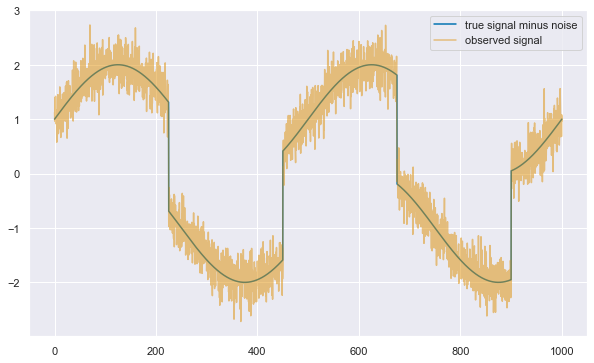

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(t, signal1 + signal2, label='true signal minus noise')
plt.plot(t, y, alpha=0.5, label='observed signal')
plt.legend()
plt.show()

# Solve problem all at once with CVXPY

In [5]:
problem = Problem(data=y, components=[GaussNoise, SmoothSecondDifference, SparseFirstDiffConvex(vavg=0)])
problem.weights.value = [1., 1e7, 10]
problem.decompose(solver=SOLVER)
problem.problem.value

261.2929263524711

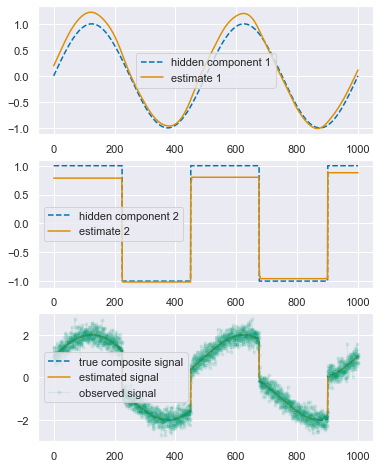

In [6]:
fig, ax = plt.subplots(nrows=3, figsize=(10//1.5, 12//1.5))
ax[0].plot(t, signal1, label='hidden component 1', ls='--')
ax[0].plot(t, problem.estimates[1], label='estimate 1')
ax[1].plot(t, signal2, label='hidden component 2', ls='--')
ax[1].plot(t, problem.estimates[2], label='estimate 2')
ax[2].plot(t, signal1 + signal2, label='true composite signal', ls='--')
ax[2].plot(t, problem.estimates[1] + problem.estimates[2], label='estimated signal');
ax[2].plot(t, y, label='observed signal', linewidth=1, marker='.', alpha=0.1);
for a in ax:
    a.legend()

# Simple implementation of ADMM algorithm

Nothing fancy here. Just a quick and dirty implementation of the three proximal operators.

In [7]:
def prox1(v, theta, rho):
    r = rho / (2 * theta + rho)
    return r * v

def prox2(v, theta, rho):
    n = len(v)
    M = np.diff(np.eye(n), axis=0, n=2)
    r = 2 * theta / rho
    A = np.linalg.inv(np.eye(n) + r * M.T.dot(M))
    return A.dot(v)

def prox3(v, theta, rho):
    n = len(v)
    M = np.diff(np.eye(n), axis=0, n=1)
    x = cvx.Variable(n)
    cost = theta * cvx.norm1(cvx.diff(x)) + (rho / 2) * cvx.sum_squares(x - v)
    problem = cvx.Problem(cvx.Minimize(cost), [cvx.sum(x) == 0])
    problem.solve()
    return x.value

In [8]:
num_iter = 50
rho = 0.5
u = np.zeros_like(y)
x1 = y / 3
x2 = y / 3
x3 = y / 3
residuals = []
for it in range(num_iter):
    x1 = prox1(x1 - u, 1, rho)
    x2 = prox2(x2 - u, 1e7, rho)
    x3 = prox3(x3 - u, 1e1, rho)
    u += 2 * (np.average([x1, x2, x3], axis=0) - y / 3)
    residuals.append(np.linalg.norm(np.average([x1, x2, x3], axis=0) - y / 3))

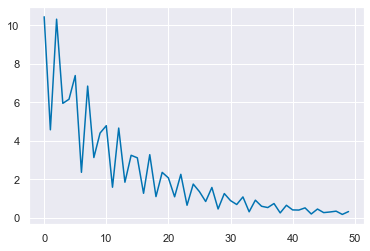

In [9]:
plt.plot(residuals)

In [10]:
num_iter = 50
rho = 5
u = np.zeros_like(y)
x1 = y / 3
x2 = y / 3
x3 = y / 3
residuals = []
for it in range(num_iter):
    x1 = prox1(x1 - u, 1, rho)
    x2 = prox2(x2 - u, 1e7, rho)
    x3 = prox3(x3 - u, 1e1, rho)
    u += 2 * (np.average([x1, x2, x3], axis=0) - y / 3)
    residuals.append(np.linalg.norm(np.average([x1, x2, x3], axis=0) - y / 3))

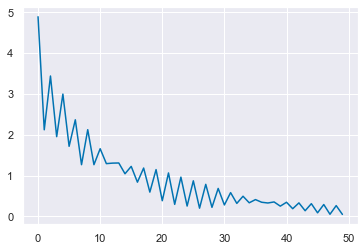

In [11]:
plt.plot(residuals)

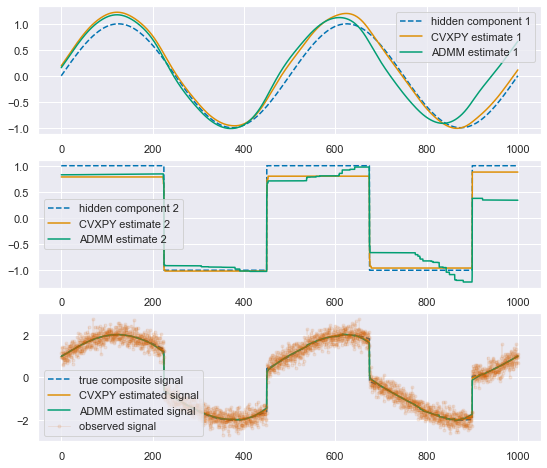

In [12]:
fig, ax = plt.subplots(nrows=3, figsize=(10//1.1, 12//1.5))
ax[0].plot(t, signal1, label='hidden component 1', ls='--')
ax[0].plot(t, problem.estimates[1], label='CVXPY estimate 1')
ax[0].plot(t, x2, label='ADMM estimate 1')
ax[1].plot(t, signal2, label='hidden component 2', ls='--')
ax[1].plot(t, problem.estimates[2], label='CVXPY estimate 2')
ax[1].plot(t, x3, label='ADMM estimate 2')
ax[2].plot(t, signal1 + signal2, label='true composite signal', ls='--')
ax[2].plot(t, problem.estimates[1] + problem.estimates[2], label='CVXPY estimated signal');
ax[2].plot(t, x2 + x3, label='ADMM estimated signal');
ax[2].plot(t, y, label='observed signal', linewidth=1, marker='.', alpha=0.1);
for a in ax:
    a.legend()

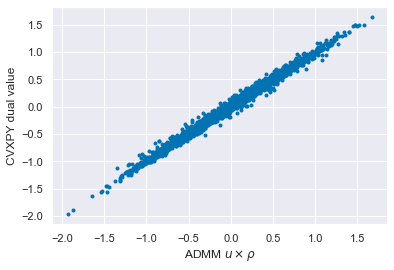

In [13]:
plt.plot(rho * u, problem.problem.constraints[-1].dual_value, ls='none', marker='.')
plt.xlabel('ADMM $u\\times\\rho$')
plt.ylabel('CVXPY dual value');

# Non-convex model

Replace the heuristic for a sparse first difference with the constraint that $x^3\in\left\{-1,1\right\}^T$.

In [14]:
def prox3(v):
    v1 = np.ones_like(v)
    v2 = -1 * np.ones_like(v)
    d1 = np.abs(v - v1)
    d2 = np.abs(v - v2)
    x = np.ones_like(v1)
    x[d2 < d1] = -1
    return x

In [15]:
num_iter = 50
rho = 5
u = np.zeros_like(y)
x1 = y / 3
x2 = y / 3
x3 = y / 3
residuals = []
for it in range(num_iter):
    x1 = prox1(x1 - u, 1, rho)
    x2 = prox2(x2 - u, 1e7, rho)
    x3 = prox3(x3 - u)
    u += 2 * (np.average([x1, x2, x3], axis=0) - y / 3)
    residuals.append(np.linalg.norm(np.average([x1, x2, x3], axis=0) - y / 3))

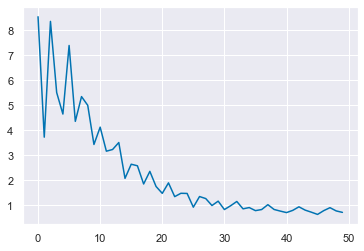

In [16]:
plt.plot(residuals)

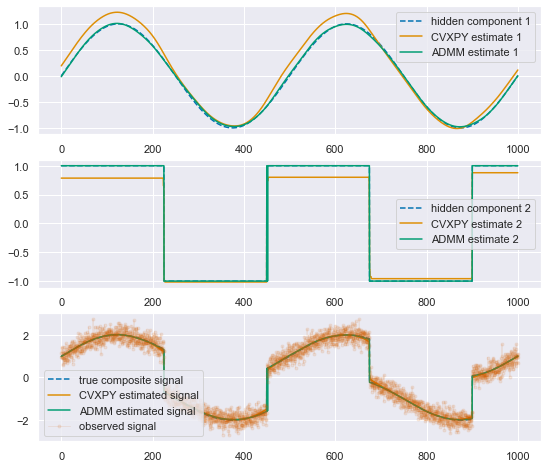

In [17]:
fig, ax = plt.subplots(nrows=3, figsize=(10//1.1, 12//1.5))
ax[0].plot(t, signal1, label='hidden component 1', ls='--')
ax[0].plot(t, problem.estimates[1], label='CVXPY estimate 1')
ax[0].plot(t, x2, label='ADMM estimate 1')
ax[1].plot(t, signal2, label='hidden component 2', ls='--')
ax[1].plot(t, problem.estimates[2], label='CVXPY estimate 2')
ax[1].plot(t, x3, label='ADMM estimate 2')
ax[2].plot(t, signal1 + signal2, label='true composite signal', ls='--')
ax[2].plot(t, problem.estimates[1] + problem.estimates[2], label='CVXPY estimated signal');
ax[2].plot(t, x2 + x3, label='ADMM estimated signal');
ax[2].plot(t, y, label='observed signal', linewidth=1, marker='.', alpha=0.1);
for a in ax:
    a.legend()